In [1]:
### import copy
import pickle
import random
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations
import os

import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# Loading starting data

In [2]:
book_data = pd.read_csv("BDM_ColdWar.csv")
book_data.Position = (book_data.Position + 100)/200

# Unserialize run data

In [3]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [4]:
model_runs = []
filename = "data_output/ColdWar_Experiment1_5.pickle"
with open(filename, "rb") as f:
    model_runs += pickle.load(f)

# Get agent positions

In [5]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.agent_vars.copy()
    df.reset_index(inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
agent_positions = pd.concat(all_dfs)

In [6]:
agent_positions.tail()

,Step,AgentID,Position,Iteration
895,24,Thailand,0.506500,999
896,24,Turkey,0.513153,999
897,24,USA,0.948000,999
898,24,USSR,0.005371,999
899,24,Yugoslavia,0.012684,999


## How far do agents end up from their starting positions?

In [7]:
end_positions = agent_positions[agent_positions.Step==24]\
    .groupby("AgentID")["Position"].aggregate([np.mean, np.std])

end_positions = end_positions.rename(columns={"mean": "EndPos_mean",
                             "std": "EndPos_std"})

end_positions = end_positions.merge(book_data, left_index=True, right_on="Country")
end_positions["Delta"] = end_positions.EndPos_mean - end_positions.Position

In [8]:
end_positions.head()

,EndPos_mean,EndPos_std,Country,Capability,Position,Delta
0,0.902720,0.073704,Argentina,0.972,0.9480,-0.045280
1,0.507630,0.013952,Australia,0.889,0.5065,0.001130
2,0.513590,0.004557,Belgium,1.182,0.5140,-0.000410
3,0.917742,0.059311,Brazil,0.993,0.9480,-0.030258
4,0.111392,0.058374,Bulgaria,0.345,0.0000,0.111392


0.0142093621278
-0.0610065350421
0.111392062624


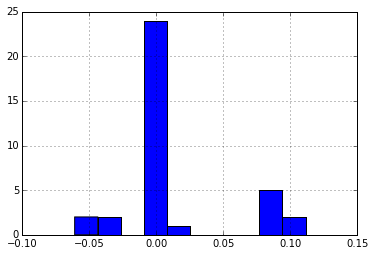

In [9]:
print(end_positions.Delta.mean())
print(end_positions.Delta.min())
print(end_positions.Delta.max())
end_positions.Delta.hist()

## Dyadic distance

In [10]:
agent_positions.tail()

,Step,AgentID,Position,Iteration
895,24,Thailand,0.506500,999
896,24,Turkey,0.513153,999
897,24,USA,0.948000,999
898,24,USSR,0.005371,999
899,24,Yugoslavia,0.012684,999


In [11]:
STEP = 24

In [12]:
distances = defaultdict(lambda: defaultdict(list))
for i, group in agent_positions.groupby("Iteration"):
    group = group[group.Step==STEP]
    for i, r1 in group.iterrows():
        source_name = r1.AgentID
        source_pos = r1.Position
        for j, r2 in group.iterrows():
            target_name = r2.AgentID
            target_pos = r2.Position
            if target_name == source_name:
                continue
            distances[source_name][target_name].append(abs(source_pos - target_pos))

In [13]:
distances = {key: dict(val) for key, val in distances.items()}

In [14]:
mean_distances = {}
for source, targets in distances.items():
    for target, dist_list in targets.items():
        mean_dist = np.mean(dist_list)
        mean_distances[(source, target)] = mean_dist

In [15]:
mean_distances = pd.DataFrame({"Mean_Distance": mean_distances})
mean_distances.reset_index(inplace=True)

In [16]:
mean_distances.rename(columns={"level_0": "Source", "level_1": "Target"}, inplace=True)

In [17]:
mean_distances.head()

,Source,Target,Mean_Distance
0,Argentina,Australia,0.395090
1,Argentina,Belgium,0.389130
2,Argentina,Brazil,0.048562
3,Argentina,Bulgaria,0.791328
4,Argentina,Canada,0.114141


# Getting alliance network

In [18]:
COW = "/Users/dmasad/Data/COW/"
YEAR = 1998
alliance_dyads = pd.read_csv(COW + "Alliances/alliance_v4.1_by_dyad_yearly.csv")
alliance_dyads = alliance_dyads[alliance_dyads.year==YEAR]
alliance_dyads["Alliance"] = 0
alliance_dyads.loc[(alliance_dyads.entente==1),"Alliance"] = 1
alliance_dyads.loc[(alliance_dyads.nonaggression==1),"Alliance"] = 2
alliance_dyads.loc[(alliance_dyads.neutrality==1),"Alliance"] = 3
alliance_dyads.loc[(alliance_dyads.defense==1),"Alliance"] = 4

In [19]:
alliance_dyads.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version,Alliance
182,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1,0,1998,4.1,4
3712,88,130,Ecuador,145,Bolivia,17,4,1911,NaN,NaN,2012,0,1,0,1,1,0,1998,4.1,3
7460,170,145,Bolivia,150,Paraguay,21,7,1938,NaN,NaN,2012,0,1,0,0,1,0,1998,4.1,2
7638,185,100,Colombia,101,Venezuela,17,12,1939,NaN,NaN,2012,0,1,0,0,1,0,1998,4.1,2
8343,199,435,Mauritania,520,Somalia,22,1,1974,NaN,NaN,2012,0,1,0,0,1,1,1998,4.1,2


In [20]:
state_names = set(alliance_dyads.state_name1.unique())\
        .union(set(alliance_dyads.state_name2.unique()))

In [21]:
for name in mean_distances.Source.unique():
    if name not in state_names:
        print(name)

Czechoslovakia
England
Iran
Sweden
Thailand
USA
USSR


In [22]:
mean_distances.replace(["England", "USSR", "USA"], 
                       ["United Kingdom", "Russia", "United States of America"], inplace=True)

In [23]:
alliance_dyads = alliance_dyads[["state_name1", "state_name2", "Alliance"]]

In [24]:
alliances = alliance_dyads.set_index(["state_name1", "state_name2"]).Alliance

In [25]:
alliance_types = {}
for state_1, state_2 in permutations(state_names, 2):
    if (state_2, state_1) in alliance_types:
        continue
    elif (state_2, state_1) in alliances:
        continue
    elif (state_1, state_2) in alliances:
        if type(alliances[(state_1, state_2)]) is pd.Series:
            alliance_types[(state_1, state_2)] = alliances[(state_1, state_2)].max()
        else:
            alliance_types[(state_1, state_2)] = alliances[(state_1, state_2)]
    else:
        alliance_types[(state_1, state_2)] = 0 

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


In [26]:
all_alliances = pd.DataFrame({"Alliance": alliance_types})

In [27]:
all_alliances.reset_index(inplace=True)
all_alliances.rename(columns={"level_0": "Source", "level_1": "Target"}, inplace=True)

In [28]:
merged_data = all_alliances.merge(mean_distances, on=["Source", "Target"])

In [29]:
merged_data.Mean_Distance = abs(merged_data.Mean_Distance)

In [30]:
merged_data.head()

,Source,Target,Alliance,Mean_Distance
0,Argentina,Denmark,0,0.395599
1,Argentina,Italy,0,0.395713
2,Argentina,Norway,0,0.395409
3,Argentina,Philippines,0,0.395287
4,Argentina,Poland,0,0.769585


In [31]:
merged_data.corr()

,Alliance,Mean_Distance
Alliance,1.000000,-0.217156
Mean_Distance,-0.217156,1.000000


In [32]:
merged_data.to_csv("transfer/ex1_data.csv")

In [ ]:
merged_data["Const."] = 1

In [ ]:
mn = sm.MNLogit(merged_data.Alliance, merged_data[["Const.", "Mean_Distance"]]).fit()
print(mn.summary())

In [ ]:
with open("transfer/mn_ex_1.pickle", "wb") as f:
    pickle.dump(mn, f)

In [ ]:
plt.scatter(merged_data.Mean_Distance, merged_data.Alliance)

# Export to R for ergm

In [32]:
adj_mat = merged_data.pivot("Source", "Target", "Alliance").fillna(0)

In [35]:
adj_mat.replace([1, 2, 3], [0, 0, 0], inplace=True)
adj_mat.replace(4, 1, inplace=True)

In [36]:
dist = merged_data.pivot("Source", "Target", "Mean_Distance").fillna(0)

In [38]:
adj_mat.to_csv("transfer/alliance_adj_mat.csv")

In [39]:
dist.to_csv("transfer/ex1_dist.csv")

In [40]:
dist.index

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Bulgaria', 'Canada',
       'China', 'Denmark', 'Egypt', 'France', 'Greece', 'Hungary', 'India',
       'Iraq', 'Israel', 'Italy', 'Mexico', 'Netherlands', 'Norway',
       'Pakistan', 'Poland', 'Romania', 'Russia', 'Saudi Arabia',
       'South Africa', 'Spain', 'Syria', 'Turkey', 'United Kingdom',
       'United States of America', 'Yugoslavia'],
      dtype='object', name='Source')

In [41]:
adj_mat.index

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Bulgaria', 'Canada',
       'China', 'Denmark', 'Egypt', 'France', 'Greece', 'Hungary', 'India',
       'Iraq', 'Israel', 'Italy', 'Mexico', 'Netherlands', 'Norway',
       'Pakistan', 'Poland', 'Romania', 'Russia', 'Saudi Arabia',
       'South Africa', 'Spain', 'Syria', 'Turkey', 'United Kingdom',
       'United States of America', 'Yugoslavia'],
      dtype='object', name='Source')